In [1]:
pip install tensorflow opencv-python scikit-learn numpy

In [2]:
!pip install opencv-python
!pip install matplotlib
!pip install kaggle


In [3]:
from google.colab import files

In [4]:
# Upload your Kaggle API token JSON file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download shyambhu/hands-and-palm-images-dataset

100% 633M/634M [00:05<00:00, 164MB/s]
100% 634M/634M [00:05<00:00, 131MB/s]


In [7]:
!unzip -qq "/content/hands-and-palm-images-dataset.zip"

In [8]:
import cv2
import matplotlib.pyplot as plt

In [9]:
  import tensorflow as tf
  from tensorflow.keras import layers, models
  from sklearn.model_selection import train_test_split
  import numpy as np
  import cv2
  import os

In [28]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load dataset and CSV file
data = pd.read_csv(r"/content/HandInfo.csv")

# Data preprocessing
image_dir = r"/content/Hands/Hands"


In [11]:
print(data.head())

   id  age gender skinColor  accessories  nailPolish  aspectOfHand  \
0   0   27   male      fair            0           0  dorsal right   
1   0   27   male      fair            0           0  dorsal right   
2   0   27   male      fair            0           0  dorsal right   
3   0   27   male      fair            0           0  dorsal right   
4   0   27   male      fair            0           0  dorsal right   

          imageName  irregularities  
0  Hand_0000002.jpg               0  
1  Hand_0000003.jpg               0  
2  Hand_0000004.jpg               0  
3  Hand_0000005.jpg               0  
4  Hand_0000006.jpg               0  


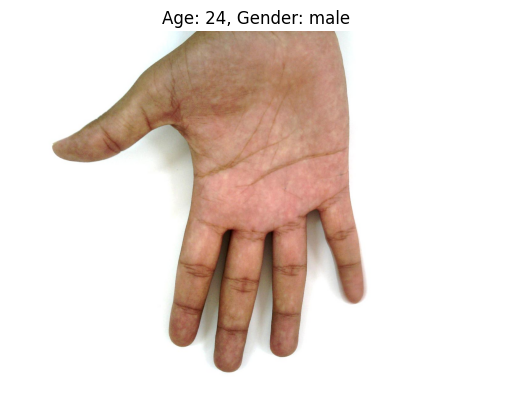

In [29]:
import matplotlib.pyplot as plt
import random

# Assuming 'data' contains your dataset and 'image_dir' is the directory of your images

# Select a random index
random_index = random.randint(0, len(data) - 1)

# Get the image file name and label
image_name = data.loc[random_index, 'imageName']
age_label = data.loc[random_index, 'age']
gender_label = data.loc[random_index, 'gender']

# Load and display the image
image_path = os.path.join(image_dir, image_name)
image = plt.imread(image_path)

plt.imshow(image)
plt.title(f'Age: {age_label}, Gender: {gender_label}')
plt.axis('off')
plt.show()


In [13]:
pip install efficientnet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.2 MB/s eta 0:00:00


In [44]:
import tensorflow as tf
from tensorflow.keras import layers
from efficientnet.tfkeras import EfficientNetB0

# Function to create an EfficientNet model for gender prediction
def create_gender_model(input_shape=(224, 224, 3)):
    base_model = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')

    # Freeze the convolutional base
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid', name='gender_encoded')  # Gender prediction
    ])

    return model

gender_model = create_gender_model()

gender_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

gender_model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functiona  (None, 7, 7, 1280)        4049564   
 l)                                                              
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
 2 (GlobalAveragePooling2D)                                      
                                                                 
 dense_12 (Dense)            (None, 128)               163968    
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 gender_encoded (Dense)      (None, 1)                 129       
                                                                 
Total params: 4213661 (16.07 MB)
Trainable params: 164

In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split



# Step 1: Drop rows where 'accessories' is True
data_filtered = data[data['accessories'] == False]

# Encode 'gender' labels
label_encoder = LabelEncoder()
data_filtered['gender_encoded'] = label_encoder.fit_transform(data_filtered['gender'])

# Image data generators
datagen = ImageDataGenerator(rescale=1./255)
image_size = (224, 224)
# Read labels and image names for training
train_labels = pd.read_csv(r"/content/drive/MyDrive/drive-download-20231218T134646Z-001/g_training_d.txt", header=None, names=['gender'])
train_image_names = pd.read_csv(r"/content/drive/MyDrive/drive-download-20231218T134646Z-001/g_imgs_training_d.txt", header=None, names=['imageName'])
train_data = pd.concat([train_labels, train_image_names], axis=1)

# Read labels and image names for testing
test_labels = pd.read_csv(r"/content/drive/MyDrive/drive-download-20231218T134646Z-001/g_testing_d.txt", header=None, names=['gender'])
test_image_names = pd.read_csv(r"/content/drive/MyDrive/drive-download-20231218T134646Z-001/g_imgs_testing_d.txt", header=None, names=['imageName'])
test_data = pd.concat([test_labels, test_image_names], axis=1)

train_data['gender_encoded'] = label_encoder.fit_transform(train_data['gender'])
test_data['gender_encoded'] = label_encoder.transform(test_data['gender'])

# Display a few rows of the training and testing datasets
print("Training Data:")
print(train_data)

print("\nTesting Data:")
print(test_data)


# print(image_dir)
print(image_size)
train_datagen_dorsal = datagen.flow_from_dataframe(
    train_data,
    directory=image_dir,
    x_col='imageName',
    y_col='gender',
    target_size=image_size,
    class_mode="binary",
    batch_size=32,
    subset=None  # Add this line to ensure RGB color mode
)

test_datagen_dorsal = datagen.flow_from_dataframe(
    test_data,
    directory=image_dir,
    x_col='imageName',
    y_col='gender',
    target_size=image_size,
    class_mode="binary",
    batch_size=32,
    subset=None # Add this line to ensure RGB color mode
)

gender_model.fit(train_datagen_dorsal, epochs=15)
evaluation_results = gender_model.evaluate(test_datagen_dorsal)



Training Data:
      gender         imageName  gender_encoded
0       male  Hand_0007640.jpg               1
1     female  Hand_0003221.jpg               0
2       male  Hand_0010958.jpg               1
3       male  Hand_0011003.jpg               1
4     female  Hand_0010228.jpg               0
...      ...               ...             ...
1995    male  Hand_0007694.jpg               1
1996    male  Hand_0002628.jpg               1
1997    male  Hand_0006893.jpg               1
1998  female  Hand_0008346.jpg               0
1999    male  Hand_0006883.jpg               1

[2000 rows x 3 columns]

Testing Data:
     gender         imageName  gender_encoded
0      male  Hand_0006963.jpg               1
1    female  Hand_0008318.jpg               0
2    female  Hand_0003558.jpg               0
3    female  Hand_0005340.jpg               0
4    female  Hand_0006371.jpg               0
..      ...               ...             ...
995    male  Hand_0009373.jpg               1
996    male  

<ipython-input-45-d75659a38a07>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['gender_encoded'] = label_encoder.fit_transform(data_filtered['gender'])


Epoch 1/15
63/63 [==============================] - 21s 243ms/step - loss: 0.4910 - accuracy: 0.7555
Epoch 2/15
63/63 [==============================] - 16s 251ms/step - loss: 0.3391 - accuracy: 0.8565
Epoch 3/15
63/63 [==============================] - 16s 248ms/step - loss: 0.2730 - accuracy: 0.8950
Epoch 4/15
63/63 [==============================] - 15s 237ms/step - loss: 0.2321 - accuracy: 0.9065
Epoch 5/15
63/63 [==============================] - 16s 255ms/step - loss: 0.2190 - accuracy: 0.9185
Epoch 6/15
63/63 [==============================] - 16s 248ms/step - loss: 0.1918 - accuracy: 0.9260
Epoch 7/15
63/63 [==============================] - 15s 237ms/step - loss: 0.1697 - accuracy: 0.9380
Epoch 8/15
63/63 [==============================] - 16s 250ms/step - loss: 0.1611 - accuracy: 0.9425
Epoch 9/15
63/63 [==============================] - 17s 272ms/step - loss: 0.1400 - accuracy: 0.9490
Epoch 10/15
63/63 [==============================] - 15s 244ms/step - loss: 0.1174 - accura